In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import numexpr as ne
from scipy.ndimage import correlate1d
from dphutils import scale
import scipy.signal
from timeit import Timer

In [2]:
import pyfftw

# test monkey patching (it doesn't work for rfftn)
a = pyfftw.empty_aligned((512, 512), dtype='complex128')
b = pyfftw.empty_aligned((512, 512), dtype='complex128')

a[:] = np.random.randn(512, 512) + 1j*np.random.randn(512, 512)
b[:] = np.random.randn(512, 512) + 1j*np.random.randn(512, 512)

t = Timer(lambda: scipy.signal.fftconvolve(a, b, 'same'))

print('Time with scipy.fftpack: %1.3f seconds' % t.timeit(number=10))

# Monkey patch in fftn and ifftn from pyfftw.interfaces.scipy_fftpack
scipy.signal.signaltools.fftn = pyfftw.interfaces.scipy_fftpack.fftn
scipy.signal.signaltools.ifftn = pyfftw.interfaces.scipy_fftpack.ifftn
scipy.signal.signaltools.fftpack = pyfftw.interfaces.scipy_fftpack
# can't monkey patch the rfft because it's used through np in the package.
scipy.signal.fftconvolve(a, b, 'same') # We cheat a bit by doing the planning first

# Turn on the cache for optimum performance
pyfftw.interfaces.cache.enable()

print('Time with monkey patched scipy_fftpack: %1.3f seconds' %
       t.timeit(number=10))

Time with scipy.fftpack: 2.300 seconds
Time with monkey patched scipy_fftpack: 1.120 seconds


In [3]:
# Testing the best method to enforce positivity constraint.
a = np.random.randn(1e3,1e3)
print(a.max(), a.min())
%timeit a[a<0] = 0
print(a.max(), a.min())

a = np.random.randn(1e3,1e3)
b=np.zeros_like(a)
print(a.max(), a.min())
%timeit c = np.minimum(a,b)
print(a.max(), a.min())

4.78898193194 -4.60097336282
The slowest run took 19.30 times longer than the fastest. This could mean that an intermediate result is being cached.

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



1000 loops, best of 3: 535 µs per loop
4.78898193194 0.0
4.84342093862 -4.8453365227
100 loops, best of 3: 8.79 ms per loop
4.84342093862 -4.8453365227


In [4]:
# testing speedups for numexpr
a = np.random.randn(2**9,2**9)
b = np.random.randn(2**9,2**9)

%timeit a-b
%timeit ne.evaluate("a-b")

%timeit a/b
%timeit ne.evaluate("a/b")

1000 loops, best of 3: 723 µs per loop
1000 loops, best of 3: 920 µs per loop
1000 loops, best of 3: 1.21 ms per loop
1000 loops, best of 3: 851 µs per loop


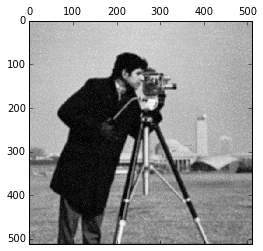

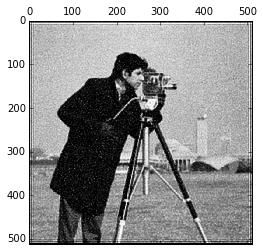

In [5]:
# Standard Richardson-Lucy form skimage
from skimage import color, data, restoration
camera = color.rgb2gray(data.camera())
from scipy.signal import convolve2d
psf = np.ones((5, 5)) / 25
camera = convolve2d(camera, psf, 'same')
camera += 0.1 * camera.std() * np.random.poisson(size=camera.shape)
deconvolved = restoration.richardson_lucy(camera, psf, 30, False)
plt.matshow(camera, cmap='Greys_r')
plt.matshow(deconvolved, cmap='Greys_r', vmin=camera.min(), vmax=camera.max())

In [6]:
# test monkey patching properly.
from pyfftw.interfaces.numpy_fft import (ifftshift, fftshift, fftn, ifftn,
                                            rfftn, irfftn)

from scipy.signal.signaltools import _rfft_lock, _rfft_mt_safe, _next_regular,_check_valid_mode_shapes,_centered

def fftconvolve2(in1, in2, mode="full"):

    if in1.ndim == in2.ndim == 0:  # scalar inputs
        return in1 * in2
    elif not in1.ndim == in2.ndim:
        raise ValueError("in1 and in2 should have the same dimensionality")
    elif in1.size == 0 or in2.size == 0:  # empty arrays
        return array([])

    s1 = np.array(in1.shape)
    s2 = np.array(in2.shape)
    complex_result = (np.issubdtype(in1.dtype, complex) or
                      np.issubdtype(in2.dtype, complex))
    shape = s1 + s2 - 1

    if mode == "valid":
        _check_valid_mode_shapes(s1, s2)

    # Speed up FFT by padding to optimal size for FFTPACK
    fshape = [_next_regular(int(d)) for d in shape]
    fslice = tuple([slice(0, int(sz)) for sz in shape])
    # Pre-1.9 NumPy FFT routines are not threadsafe.  For older NumPys, make
    # sure we only call rfftn/irfftn from one thread at a time.
    if not complex_result and (_rfft_mt_safe or _rfft_lock.acquire(False)):
        try:
            ret = (irfftn(rfftn(in1, fshape) *
                                 rfftn(in2, fshape), fshape)[fslice].
                   copy())
        finally:
            if not _rfft_mt_safe:
                _rfft_lock.release()
    else:
        # If we're here, it's either because we need a complex result, or we
        # failed to acquire _rfft_lock (meaning rfftn isn't threadsafe and
        # is already in use by another thread).  In either case, use the
        # (threadsafe but slower) SciPy complex-FFT routines instead.
        ret = ifftn(fftn(in1, fshape) *
                            fftn(in2, fshape))[fslice].copy()
        if not complex_result:
            ret = ret.real

    if mode == "full":
        return ret
    elif mode == "same":
        return _centered(ret, s1)
    elif mode == "valid":
        return _centered(ret, s1 - s2 + 1)
    else:
        raise ValueError("Acceptable mode flags are 'valid',"
                         " 'same', or 'full'.")

In [9]:
%timeit scipy.signal.fftconvolve(camera, psf, 'same')
%timeit fftconvolve2(camera, psf, 'same')

10 loops, best of 3: 34.8 ms per loop
100 loops, best of 3: 15.2 ms per loop


In [11]:
def tv(im):
    """
    Calculate the total variation image
    
    (1) Laasmaa, M.; Vendelin, M.; Peterson, P. Application of Regularized Richardson–Lucy Algorithm for
    Deconvolution of Confocal Microscopy Images. Journal of Microscopy 2011, 243 (2), 124–140.
    
    dx.doi.org/10.1111/j.1365-2818.2011.03486.x
    """
    
    def m(a, b):
        '''
        As described in (1)
        '''
        return (sign(a)+sign(b))/2*minimum(abs(a), abs(b))

    ndim = im.ndim
    g = np.zeros_like(p)
    i = 0
    
    # g stores the gradients of out along each axis
    # e.g. g[0] is the first order finite difference along axis 0
    for ax in range(ndim):
        a = 2*ax
        # backward difference
        g[a] = correlate1d(im, [-1, 1], ax)
        # forward difference
        g[a+1] = correlate1d(im, [-1, 1], ax, origin=-1)

    eps = finfo(float).eps
    oym, oyp, oxm, oxp = g 
    
    return oxm*oxp/sqrt(oxp**2 +m(oyp,oym)**2+eps)+oym*oyp/sqrt(oyp**2 +m(oxp,oxm)**2+eps)


def rl_update(convolve_method, kwargs):
    '''
    A function that represents the core rl operation:
    $u^{(t+1)} = u^{(t)}\cdot\left(\frac{d}{u^{(t)}\otimes p}\otimes \hat{p}\right)$
    
    Parameters
    ----------
    image : ndarray
        original image to be deconvolved
    u_tm1 : ndarray
        previous
    u_t
    u_tp1
    psf
    convolve_method
    '''
    
    image = kwargs['image']
    psf = kwargs['psf']
    # use the prediction step to iterate on
    y_t = kwargs['y_t']
    u_t = kwargs['u_t']
    u_tm1 = kwargs['u_tm1']
    g_tm1 = kwargs['g_tm1']
    psf_mirror = psf[::-1, ::-1]
    blur = convolve_method(y_t, psf, 'same')
    relative_blur = ne.evaluate("image / blur")
    blur_blur = convolve_method(relative_blur, psf_mirror, 'same')
    u_tp1 = ne.evaluate("y_t*blur_blur")
    u_tp1[u_tp1 < 0] = 0
    # update
    
    
    kwargs.update(dict(
            u_tm2 = u_tm1,
            u_tm1 = u_t,
            u_t = u_tp1,
            blur = blur_blur,
            g_tm2 = g_tm1,
            g_tm1 = ne.evaluate("u_tp1 - y_t")
        ))


def richardson_lucy(image, psf, iterations=50, clip=False):
    """Richardson-Lucy deconvolution.
    Parameters
    ----------
    image : ndarray
       Input degraded image (can be N dimensional).
    psf : ndarray
       The point spread function.
    iterations : int
       Number of iterations. This parameter plays the role of
       regularisation.
    clip : boolean, optional
       True by default. If true, pixel value of the result above 1 or
       under -1 are thresholded for skimage pipeline compatibility.
    Returns
    -------
    im_deconv : ndarray
       The deconvolved image.
    Examples
    --------
    >>> from skimage import color, data, restoration
    >>> camera = color.rgb2gray(data.camera())
    >>> from scipy.signal import convolve2d
    >>> psf = np.ones((5, 5)) / 25
    >>> camera = convolve2d(camera, psf, 'same')
    >>> camera += 0.1 * camera.std() * np.random.standard_normal(camera.shape)
    >>> deconvolved = restoration.richardson_lucy(camera, psf, 5, False)
    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
    """
    # Stolen from the dev branch of skimage because stable branch is slow
    # compute the times for direct convolution and the fft method. The fft is of
    # complexity O(N log(N)) for each dimension and the direct method does
    # straight arithmetic (and is O(n*k) to add n elements k times)
    direct_time = np.prod(image.shape + psf.shape)
    fft_time = np.sum([n*np.log(n) for n in image.shape + psf.shape])

    # see whether the fourier transform convolution method or the direct
    # convolution method is faster (discussed in scikit-image PR #1792)
    time_ratio = 40.032 * fft_time / direct_time

    if time_ratio <= 1 or len(image.shape) > 2:
        convolve_method = fftconvolve2
    else:
        convolve_method = convolve

    image = image.astype(np.float)
    psf = psf.astype(np.float)
    im_deconv = 0.5 * np.ones(image.shape)
    
    psf_mirror = psf[::-1, ::-1]
    
    rl_dict = dict(
        image=image,
        u_tm2=None,
        u_tm1=None,
        g_tm2=None,
        g_tm1=None,
        u_t=None,
        y_t=image,
        psf=psf
    )
    
    for i in range(iterations):
        # d/(u_t \otimes p)
        
        rl_update(convolve_method, rl_dict)
        alpha = 0
        
        if rl_dict['g_tm1'] is not None and rl_dict['g_tm2'] is not None and i > 1:
            alpha = (rl_dict['g_tm1'] * rl_dict['g_tm2']).sum()/(rl_dict['g_tm2']**2).sum()
            alpha = max(min(alpha,1),0)
        
        if alpha != 0:            
            if rl_dict['u_tm1'] is not None:
                h1_t = rl_dict['u_t'] - rl_dict['u_tm1']
                h1_t
                if rl_dict['u_tm2'] is not None:
                    h2_t = rl_dict['u_t'] - 2 * rl_dict['u_tm1'] + rl_dict['u_tm2']
                else:
                    h2_t = 0
            else:
                h1_t = 0
        else:
            h2_t = 0
            h1_t = 0
            
        rl_dict['y_t'] = rl_dict['u_t']+alpha*h1_t+alpha**2/2*h2_t
        rl_dict['y_t'][rl_dict['y_t'] < 0] = 0
        
    im_deconv = rl_dict['u_t']
    if clip:
        im_deconv[im_deconv > 1] = 1
        im_deconv[im_deconv < -1] = -1

    return rl_dict

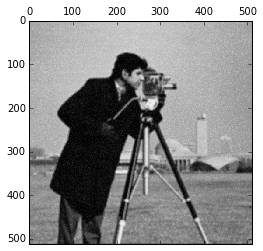

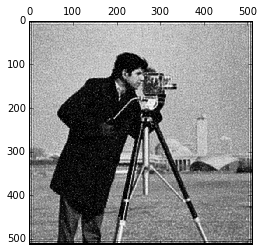

In [12]:
deconvolved2 = richardson_lucy(camera, psf, 10)

plt.matshow(camera, cmap='Greys_r')
plt.matshow(np.real(deconvolved2['u_t']), cmap='Greys_r', vmin=camera.min(), vmax=camera.max())

In [14]:
%timeit deconvolved2 = richardson_lucy(camera, psf, 10)

1 loop, best of 3: 506 ms per loop
